# Scrapping & Sentiment analysis of **US Beige book** for global US economic indicators
> Matthieu OLEKHNOVITCH - December 2024
***

This notebook outlines the research process and the results of an analysis of the US Beige book data in the context of ENSAE's Course on **Machine Learning for Portfolio Management and Trading** (2024-2025) teached by *Sylvain Champonnois*.

***

The architecture of the notebook is as follows:

0. Intuition and motivation 
1. Data collection and preprocessing
2. Sentiment analysis of the Beige book data using LLM (here we use Google AI Studio API)
3. Data visualization and overview
4. Machine learning model to predict the S&P 500 returns
5. Performance evaluation of the model
6. Critique of the model and future work

***


## 0. Intuition and motivation

The US Beige book is a report published by the Federal Reserve Bank of Philadelphia 8 times a year (approx.), providing a summary of economic conditions in the United States. It is a valuable source of information for understanding the current state of the economy, as it includes insights from the Federal Reserve's regional economic contacts. It includes both national and regional economic conditions but we will focus on the national summary.

The Beige book is a key indicator of the economic conditions in the US at a given time, and it is often used by investors and economists to make investment decisions. Therefore, the **intuition** of this notebook is that the **sentiment** conveyed by the Beige book can be used to **predict some US economic indicators**, such as the S&P 500 returns.

However, the Beige book is a summary, and not a detailed database that can be quickly used in a model. Therefore, by leveraging a LLM, we need to build features for each report.
I chose four for this analysis but a more fine-grained analysis could be conducted and may yield better results.
These features are indicators of the health of :
- Hiring market
- Consumer spending
- Economic growth
- Material prices

rated from 1 to 10 by the LLM, given that 1 is the worst and 10 is the best.

A key point of this approach is to asses that combination of theses features may lead to interesting predictions of the shifted S&P 500 returns (1 to 12 months).

```mermaid	
graph LR
    A[US Beige Book - Text] --> B(LLM);
    B --> C{Feature Extraction};
    C --> D[Hiring Market];
    C --> E[Consumer Spending];
    C --> F[Economic Growth];
    C --> G[Material Prices];
    D & E & F & G --> H{Regression Model};
    H --> I[Predicted S&P 500 Returns - Different Horizons];

```



## 1. Data collection and preprocessing

Python libraries used:

In [1]:
# Core libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
import json
import os
from dotenv import load_dotenv

# Financial data libraries & web scraping & LLM
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import google.generativeai as genai
from google.ai.generativelanguage_v1beta.types import content

# Machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

We use the yfinance library to download the S&P 500 returns.
For the Beige Book data, as a direct API to get the data is not available, we use a web scrapping approach detailed in the following section.

### 1.1 Web scraping of the Beige Book data

A clean and consistent display of the beige book report is available on the [Federal Reserve Bank of Minneapolis website](https://www.minneapolisfed.org/region-and-community/regional-economic-indicators/beige-book-archive). We use the 'National Summary' section, which is the most relevant for our analysis as it contains the most comprehensive and global information.

The logic of the web scrapping comes from the fact that each report is stored with a reproducible URL with the month and year of the report like this:

```
https://www.minneapolisfed.org/beige-book-reports/YYYY/YYYY-MM-su
```
So the process is as follows:
1. Generate the list of URLs for the reports from 2004 to 2024
2. For each URL, try and fetch the page and check if the page is a valid report.
3. If the page is a valid report, extract the text of the page.
4. Store the text in a dataframe.



In [2]:
def generate_beige_book_urls(start_date):
    """
    Generate Beige Book URLs starting from a specific date
    The URL format is: /beige-book-reports/YYYY/YYYY-MM-su
    """
    urls = []
    base_url = "https://www.minneapolisfed.org/beige-book-reports"

    for year in range(start_date, 2025):
        for month in range(1, 13):
            url = f"{base_url}/{year}/{year}-{month:02d}-su"
            urls.append({"url": url, "date": str(year) + "-" + str(month)})

    return urls


def check_url_validity(url):
    """Check if the URL returns a valid response"""
    try:
        response = requests.get(url)
        return response.status_code == 200
    except:
        return False

In [3]:
urls = generate_beige_book_urls(2004)


In [4]:
valid_urls = []
for url_data in tqdm.tqdm(urls): # Can take a while (~1 min)
    if check_url_validity(url_data["url"]):
        valid_urls.append(url_data)

urls_df = pd.DataFrame(valid_urls)
urls_df.to_csv("data/beige_book_urls.csv", index=False) # Saving in case of changes in the data


100%|██████████| 252/252 [01:36<00:00,  2.61it/s]


Then we use beautifulsoup to extract the text of the page specific to the National Summary section.
This code **may have to be updated** if the website changes.


In [5]:
# OPTIONALY USE THE SAVED DATAFRAME (uncomment the following line to use)
# urls_df = pd.read_csv("data/beige_book_urls.csv")

extract_results = []
for index, row in tqdm.tqdm(urls_df.iterrows()): # Can take a while (~1 min)
    url = row["url"]
    soup = BeautifulSoup(requests.get(url).text, "html.parser")
    labor_market_div = soup.find("h1", string="Beige Book: National Summary")
    next_sibling = labor_market_div.find_parent("div")
    extract_results.append(
        {"url": url, "next_sibling": next_sibling.text, "date": row["date"]}
    )

results_df = pd.DataFrame(extract_results)

results_df.to_csv("data/beige_book_extracted.csv", index=False)

166it [01:06,  2.50it/s]


## 2 Sentiment analysis of the Beige Book data using LLM

We use the Google AI Studio API and more specifically the "Gemini 1.5 Flash" model to extract the sentiment of the Beige Book data on the four features.

We force a Json output format with the exact structure of the following example:

```json
{
    "hiring market": 5,
    "consumer spending": 7,
    "economic growth": 8,
    "material prices": 6
}
```
It is necessary to have an API key that can be set in the .env.sample file and renamed to .env.
You can find the API key [here](https://aistudio.google.com/apikey). It is free to use.
However a rate limit may be reached if the API is used too much, in this case, add some delay in the loop to avoid it.


In [6]:
load_dotenv()
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

In [7]:
generation_config = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 40,
    "max_output_tokens": 8192,
    "response_schema": content.Schema(
        type=content.Type.OBJECT,
        enum=[],
        required=[
            "extract",
            "hiring market",
            "consumer spending",
            "economic growth",
            "material prices",
        ],
        properties={
            "extract": content.Schema(
                type=content.Type.STRING,
            ),
            "hiring market": content.Schema(
                type=content.Type.NUMBER,
            ),
            "consumer spending": content.Schema(
                type=content.Type.NUMBER,
            ),
            "economic growth": content.Schema(
                type=content.Type.NUMBER,
            ),
            "material prices": content.Schema(
                type=content.Type.NUMBER,
            ),
        },
    ),
    "response_mime_type": "application/json",
}

model = genai.GenerativeModel(
    model_name="gemini-1.5-flash",
    generation_config=generation_config,
    system_instruction="Extract the Beige Book National Summary from this html code. Provide insights with grades from 1(really bad) to 10(really good) it statements can be considered regarding the following impacts :\nhiring market, consumer spending, economic growth, material prices",
)

And we can now go through the dataframe and extract the sentiment for each report : 

In [8]:
# OPTIONALY USE THE SAVED DATAFRAME (uncomment the following line to use)
# results_df = pd.read_csv("data/beige_book_extracted.csv")

for index, row in tqdm.tqdm(results_df.iterrows()):
    response = model.generate_content(row["next_sibling"])
    try:
        parsed_response = json.loads(response.text)
        results_df.at[index, "summary"] = parsed_response
        results_df.at[index, "hiring market"] = parsed_response["hiring market"]
        results_df.at[index, "consumer spending"] = parsed_response["consumer spending"]
        results_df.at[index, "economic growth"] = parsed_response["economic growth"]
        results_df.at[index, "material prices"] = parsed_response["material prices"]
    except:
        print(f"Error parsing response for URL: {row['url']}")

results_df = results_df.drop(columns=["next_sibling"])
results_df.to_csv("data/beige_book_results_LLM.csv", index=False)

1it [00:03,  3.57s/it]

Error parsing response for URL: https://www.minneapolisfed.org/beige-book-reports/2004/2004-01-su


166it [08:47,  3.18s/it]


In [9]:
# OPTIONALY USE THE SAVED DATAFRAME (uncomment the following line to use)
#results_df = pd.read_csv("data/beige_book_results_LLM.csv")


### 1.3 Fetching the S&P 500 data

We simply use the yfinance library to download the S&P 500 data. from 2004 to 2024.

In [10]:
sp500 = yf.download("^GSPC", start="2004-01-01", end="2024-01-01", interval="1mo")

# Preprocessing (reset index and flatten multi-level column names)
sp500.reset_index(inplace=True)
sp500.columns = sp500.columns.droplevel(0)
sp500.columns = [
    "date",
    "Adj Close",
    "Close",
    "High",
    "Low",
    "Open",
    "Volume",
]

# Adding the monthly return
sp500["monthly_return"] = sp500["Adj Close"].pct_change()

results_df["date"] = pd.to_datetime(results_df["date"])
sp500["date"] = pd.to_datetime(sp500["date"])

[*********************100%***********************]  1 of 1 completed


We shift the returns to build features for the following month's return for 1 to 12 months and the cumulative return for 1 to 12 months periods after the target month.
Then we merge the two dataframes on the date column to get a dataframe with the features and the S&P 500 returns.


In [11]:
# Target return is the return between the current month and the i-th month after the current month
for i in range(1, 13):
    sp500[f"target_return_{i}"] = sp500["monthly_return"].shift(-i)
    
# Cumulative return is the cumulative return between the current month and the i-th month after the current month
for i in range(1, 13):
    sp500[f"cumulative_return_{i}"] = sp500["monthly_return"].rolling(window=i).sum().shift(-i)

# Merging
merged_df = pd.merge(
    results_df, sp500, on="date", how="inner"
)

merged_df.dropna(inplace=True)
merged_df.drop(columns=["Adj Close", "Close", "High", "Low", "Open", "Volume","summary","url"], inplace=True)

In [12]:
merged_df.to_csv("data/beige_book_merged.csv", index=False)
merged_df.head()


,date,hiring market,consumer spending,economic growth,material prices,monthly_return,target_return_1,target_return_2,target_return_3,target_return_4,...,cumulative_return_3,cumulative_return_4,cumulative_return_5,cumulative_return_6,cumulative_return_7,cumulative_return_8,cumulative_return_9,cumulative_return_10,cumulative_return_11,cumulative_return_12
1,2004-03-01,6.0,7.0,8.0,9.0,-0.016359,-0.016791,0.012083,0.017989,-0.034291,...,0.013282,-0.021009,-0.018721,-0.009358,0.004657,0.043252,0.075710,0.050419,0.069323,0.050205
2,2004-04-01,6.0,7.0,8.0,9.0,-0.016791,0.012083,0.017989,-0.034291,0.002287,...,-0.004218,-0.001931,0.007433,0.021447,0.060042,0.092501,0.067210,0.086113,0.066996,0.046887
3,2004-06-01,9.0,7.0,8.0,6.0,0.017989,-0.034291,0.002287,0.009364,0.014014,...,-0.022639,-0.008625,0.029970,0.062428,0.037138,0.056041,0.036923,0.016815,0.046767,0.046624
4,2004-07-01,7.0,6.0,7.0,8.0,-0.034291,0.002287,0.009364,0.014014,0.038595,...,0.025665,0.064260,0.096719,0.071428,0.090331,0.071214,0.051105,0.081057,0.080915,0.116883
5,2004-09-01,8.0,6.0,7.0,4.0,0.009364,0.014014,0.038595,0.032458,-0.025290,...,0.085067,0.059777,0.078680,0.059563,0.039454,0.069406,0.069263,0.105232,0.094010,0.100959


## 3. Data visualization and overview

In this section, we just quickly make sure that the data is consistent and plot some graphs to enhance our understanding of the different features.

First, we can take a look at the features extracted by the LLM and their evolution over time.

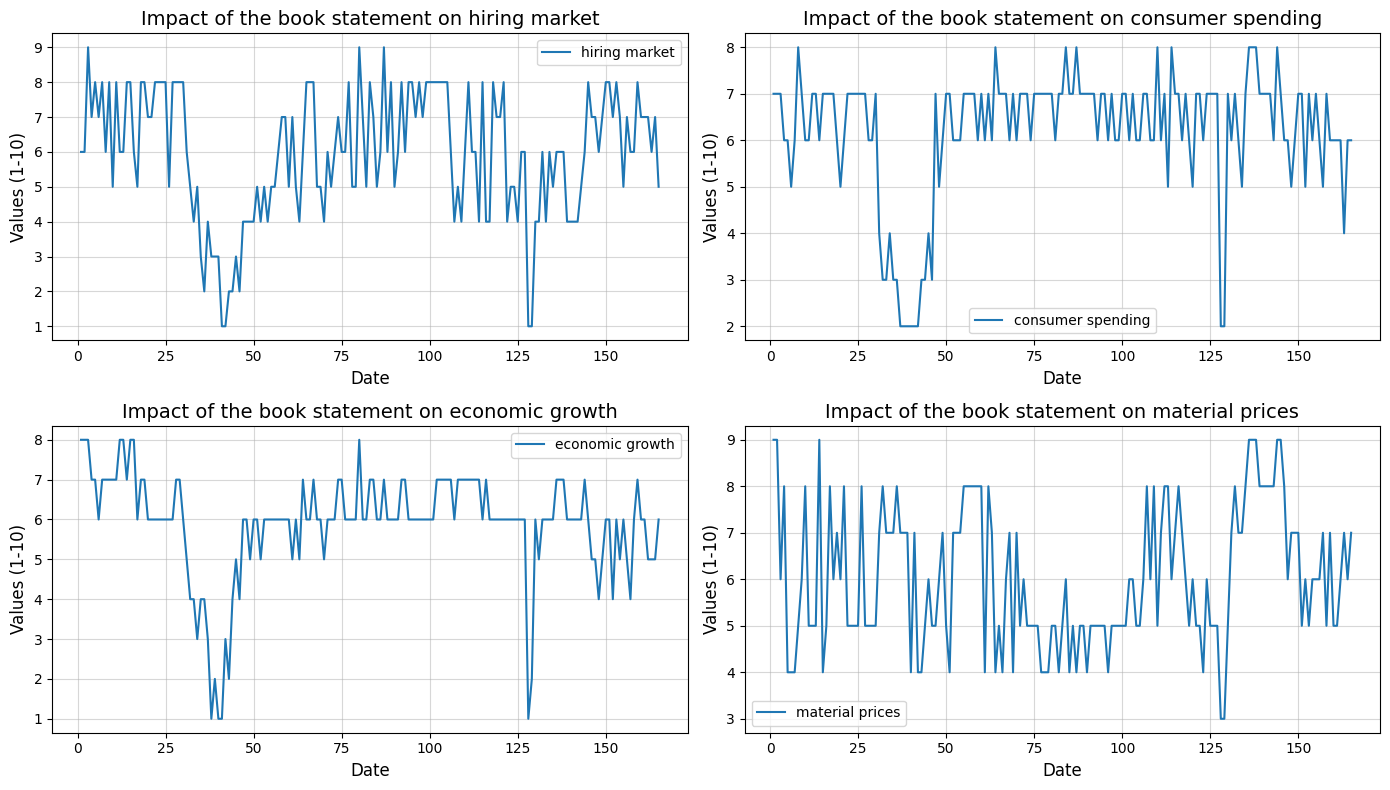

In [13]:
columns = [
    "hiring market",
    "consumer spending",
    "economic growth",
    "material prices",
]

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

for i, column in enumerate(columns):
    axs[i // 2, i % 2].plot(results_df.index, results_df[column], label=column)
    axs[i // 2, i % 2].set_title(f"Impact of the book statement on {column}", fontsize=14)
    axs[i // 2, i % 2].set_xlabel("Date", fontsize=12)
    axs[i // 2, i % 2].set_ylabel("Values (1-10)", fontsize=12)
    axs[i // 2, i % 2].legend(fontsize=10)
    axs[i // 2, i % 2].grid(alpha=0.5)

plt.tight_layout()
plt.show()

> We can visualize the 2008 and 2020 crisis quite well, which seems to confirm the LLM's ability to understand the economic situation given the beigebook extracts.

We can also visualize the cumulative return for 1 to 12 months and the monthly return.


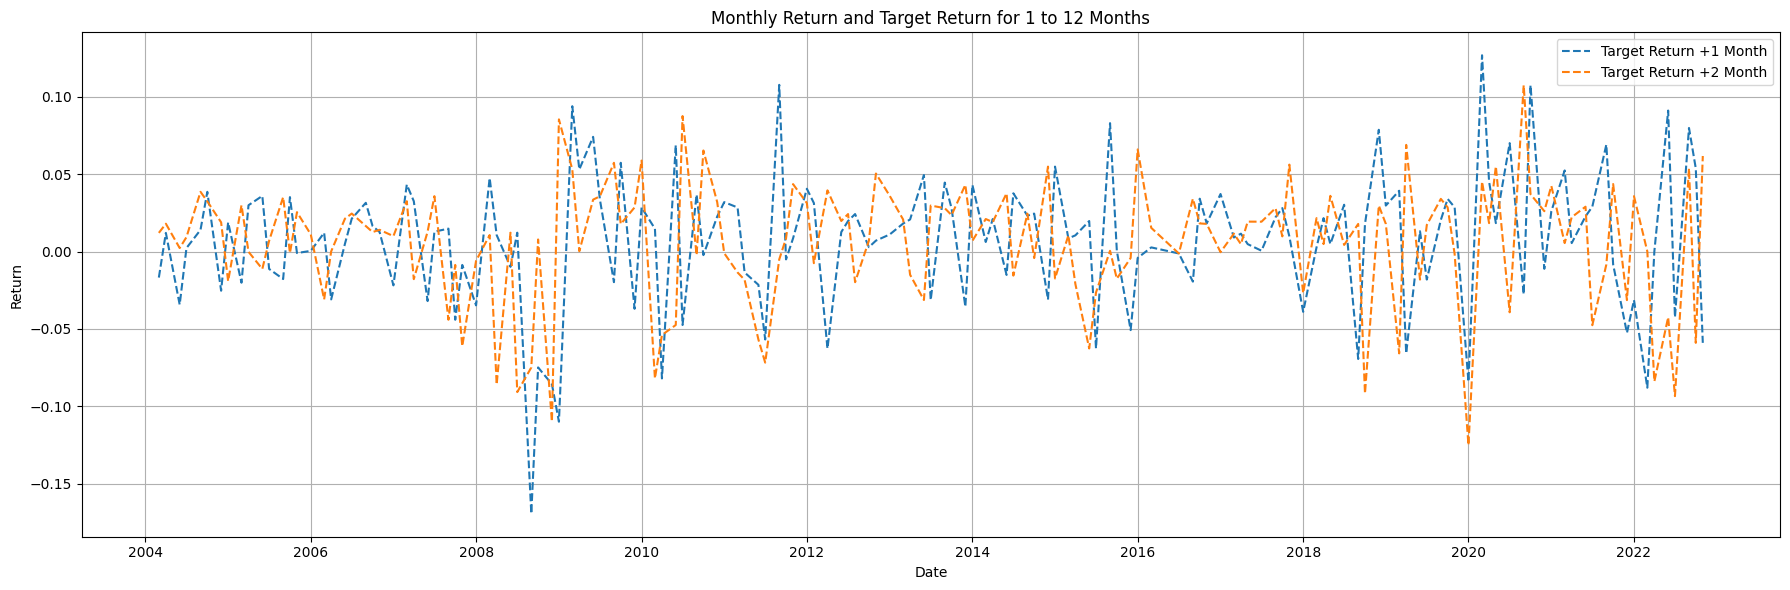

In [14]:
plt.figure(figsize=(18, 6))
for i in range(1, 3): 
    plt.plot(merged_df['date'], merged_df[f'target_return_{i}'], label=f'Target Return +{i} Month', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Monthly Return and Target Return for 1 to 12 Months")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



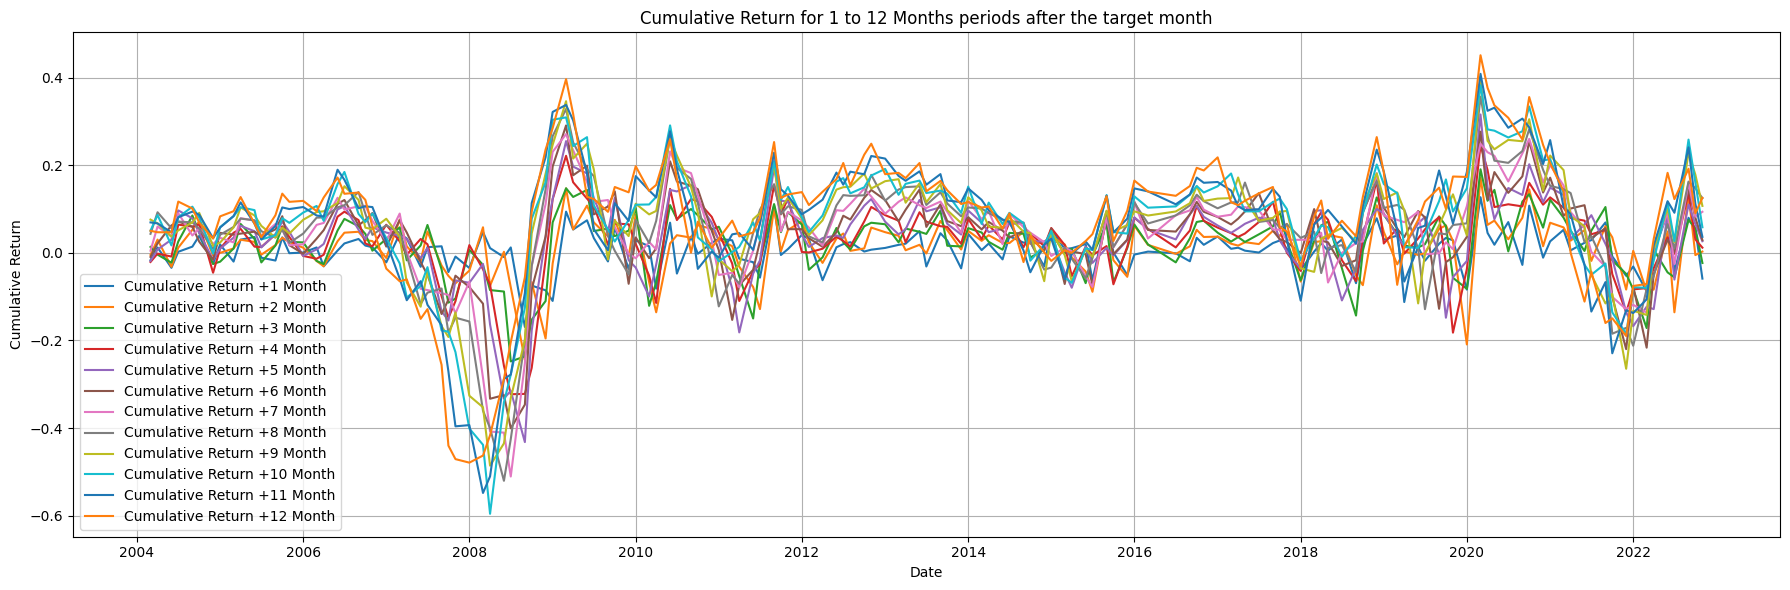

In [15]:
plt.figure(figsize=(18, 6))
for i in range(1, 13): # Show just a few cumulative for clarity
    plt.plot(merged_df['date'], merged_df[f'cumulative_return_{i}'], label=f'Cumulative Return +{i} Month')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return for 1 to 12 Months periods after the target month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Machine learning model to predict the S&P 500 returns

For the model, we will stay simple and use a Ridge Regressor (we also implemented a Random Forest Regressor for comparison).

In [16]:
def train_model(X_train, y_train, model_params):
    model = RandomForestRegressor(**model_params)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    model.fit(X_train_scaled, y_train)
    return model, scaler

def train_model_ridge(X_train, y_train, model_params):
    model = Ridge(**model_params)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    model.fit(X_train_scaled, y_train)
    return model, scaler

## 5. Performance evaluation of the model

In [17]:
def test_model(model, scaler, X_test, y_test):
    """
    Tests the model on the test set and evaluates performance.

    Args:
        model: Trained model.
        scaler: Fitted scaler from the training phase.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.

    Returns:
        dict: Performance metrics (MAE, R2, RMSE, Win Ratio).
        np.array: Model predictions.
    """
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    win_ratio = ((y_test * y_pred) > 0).mean()

    return {
        "MAE": mae,
        "R2": r2,
        "RMSE": rmse,
        "Win Ratio": win_ratio,
    }, y_pred

To test the model, we'll use a simple trading strategy based on the model's predictions, it is a simple long-short strategy based on the predicted return sign.

In [18]:
def simulate_strategy(y_test, y_pred, long_only=True):
    returns = []
    for actual, pred in zip(y_test, y_pred):
        if pred > 0:  # Predict an upward movement
            returns.append(actual)  # Buy and hold (long position)
        elif (
            not long_only and pred < 0
        ):  # Predict a downward movement (and short selling is allowed)
            returns.append(-actual)  # Short the asset
        else:
            returns.append(0)  # Stay in cash (no position)
    return np.array(returns)

We can then train and evaluate a model for each shift between 1 and 12 months and then plot some graphs to visualize the performance of the model.

In [22]:
def evaluate_and_visualize(
    merged_df,
    target_col_prefix,
    model_params,
    shifts,
    model_type="RandomForest",
    long_only=True,
):
    """
    Evaluates the model and trading strategy.
    """
    performance = []
    all_feature_importances = [] 
    pnl_series = {}

    features = [
        "hiring market",
        "consumer spending",
        "economic growth",
        "material prices",
    ]

    tscv = TimeSeriesSplit(n_splits=5) 

    for shift in shifts:
        target_col = f"{target_col_prefix}{shift}"
        X = merged_df[features]
        y = merged_df[target_col]

        all_split_returns = []
        all_test_dates = []
        fold_feature_importances = []  # Store importances for each fold

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            test_dates = y.index[test_index]

            if model_type == "RandomForest":
                model, scaler = train_model(X_train, y_train, model_params)
            elif model_type == "Ridge":
                model, scaler = train_model_ridge(X_train, y_train, model_params)
            else:
                raise ValueError("Invalid model type.")

            metrics, y_pred = test_model(model, scaler, X_test, y_test)

            # Assume simulate_strategy returns monthly returns
            split_returns = simulate_strategy(y_test, y_pred, long_only)

            all_split_returns.append(split_returns)
            all_test_dates.append(test_dates)

            if model_type == "RandomForest":
                fold_feature_importances.append(model.feature_importances_)

        # Concatenate results from all splits
        concat_returns = np.concatenate(all_split_returns)
        all_dates = np.concatenate(all_test_dates)

        # Calculate overall performance for the current shift
        overall_strategy_return = np.sum(concat_returns)

        # Annualization (assuming monthly returns from simulate_strategy)
        annualized_mean = np.mean(concat_returns) * 12
        annualized_std = np.std(concat_returns) * np.sqrt(12)
        sharpe_ratio = annualized_mean / annualized_std if annualized_std != 0 else 0

        performance.append(
            {
                "Shift (Months)": shift,
                "MAE": np.mean(metrics["MAE"]),
                "R2": np.mean(metrics["R2"]),
                "RMSE": np.mean(metrics["RMSE"]),
                "Win Ratio": np.mean(metrics["Win Ratio"]),
                "Strategy Return": overall_strategy_return,
                "Sharpe Ratio": sharpe_ratio,
            }
        )

        if model_type == "RandomForest":
            # Average feature importances across folds
            avg_feature_importances = np.mean(fold_feature_importances, axis=0)
            all_feature_importances.append(
                {
                    "Shift (Months)": shift,
                    "Feature Importances": avg_feature_importances,
                }
            )

        pnl_series[shift] = pd.Series(np.cumsum(concat_returns), index=all_dates)

    performance_df = pd.DataFrame(performance)
    feature_importance_df = pd.DataFrame(all_feature_importances)

    # Visualization
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(
        performance_df["Shift (Months)"],
        performance_df["Win Ratio"] * 100,
        label="Win Ratio (%)",
    )
    plt.xlabel("Prediction Horizon (Months)")
    plt.ylabel("Win Ratio (%)")
    plt.title("Win Ratio vs Prediction Horizon")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(
        performance_df["Shift (Months)"],
        performance_df["Strategy Return"],
        label="Strategy Return",
    )
    plt.xlabel("Prediction Horizon (Months)")
    plt.ylabel("Strategy Return")
    plt.title("Strategy Return vs Prediction Horizon")
    plt.grid()

    plt.show()
    
    plt.figure(figsize=(18,12))
    for shift, pnl in pnl_series.items():
        plt.plot(pnl.index, pnl.values, label=f"Shift {shift} Months(Sharpe Ratio: {performance_df.loc[performance_df['Shift (Months)'] == shift, 'Sharpe Ratio'].values[0]:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Cumulative PnL")
    plt.title("Cumulative PnL of Strategy by Shift")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
    if model_type == "RandomForest":
        plt.figure(figsize=(18, 6))
        
        feature_names = features
        shifts = feature_importance_df["Shift (Months)"]
        
        x = np.arange(len(shifts))
        width = 0.2 
        
        for i, feature in enumerate(feature_names):
            importances = [fi[i] for fi in feature_importance_df["Feature Importances"]]
            plt.bar(x + i*width, importances, width, label=feature)
        
        plt.xlabel("Prediction Horizon (Months)")
        plt.ylabel("Feature Importance")
        plt.title("Feature Importance vs Prediction Horizon")
        plt.xticks(x + width*1.5, shifts)
        plt.legend()
        plt.grid()
        plt.show()


### 

here, we'll be using the Ridge model with short selling allowed.


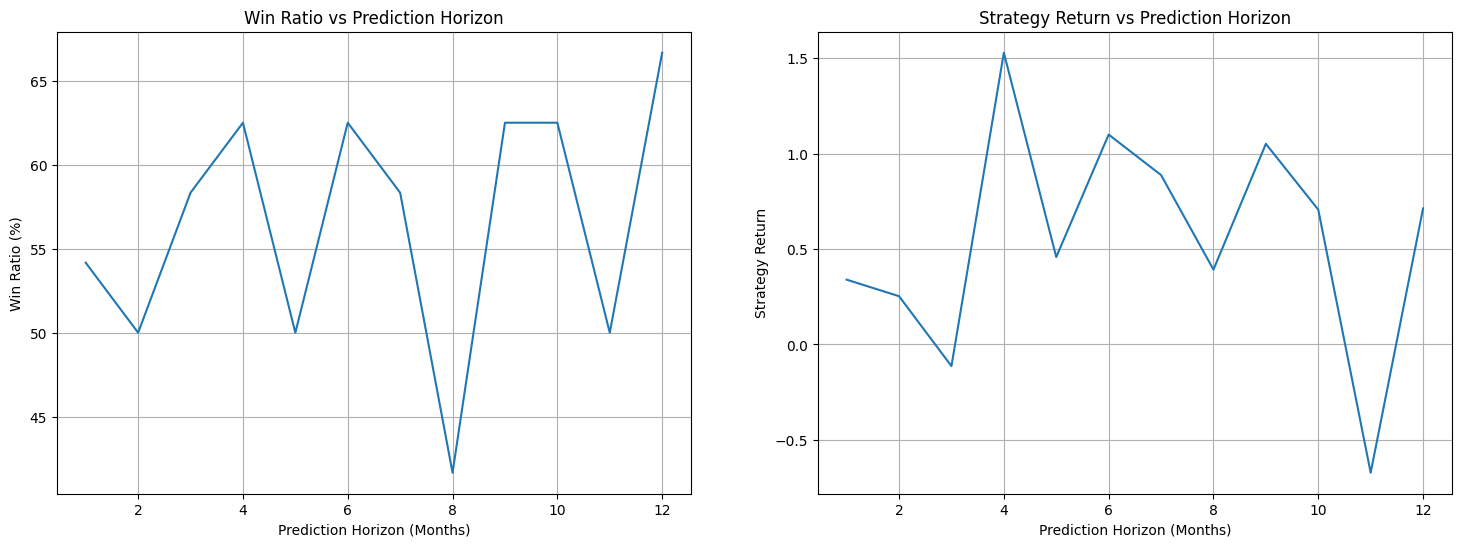

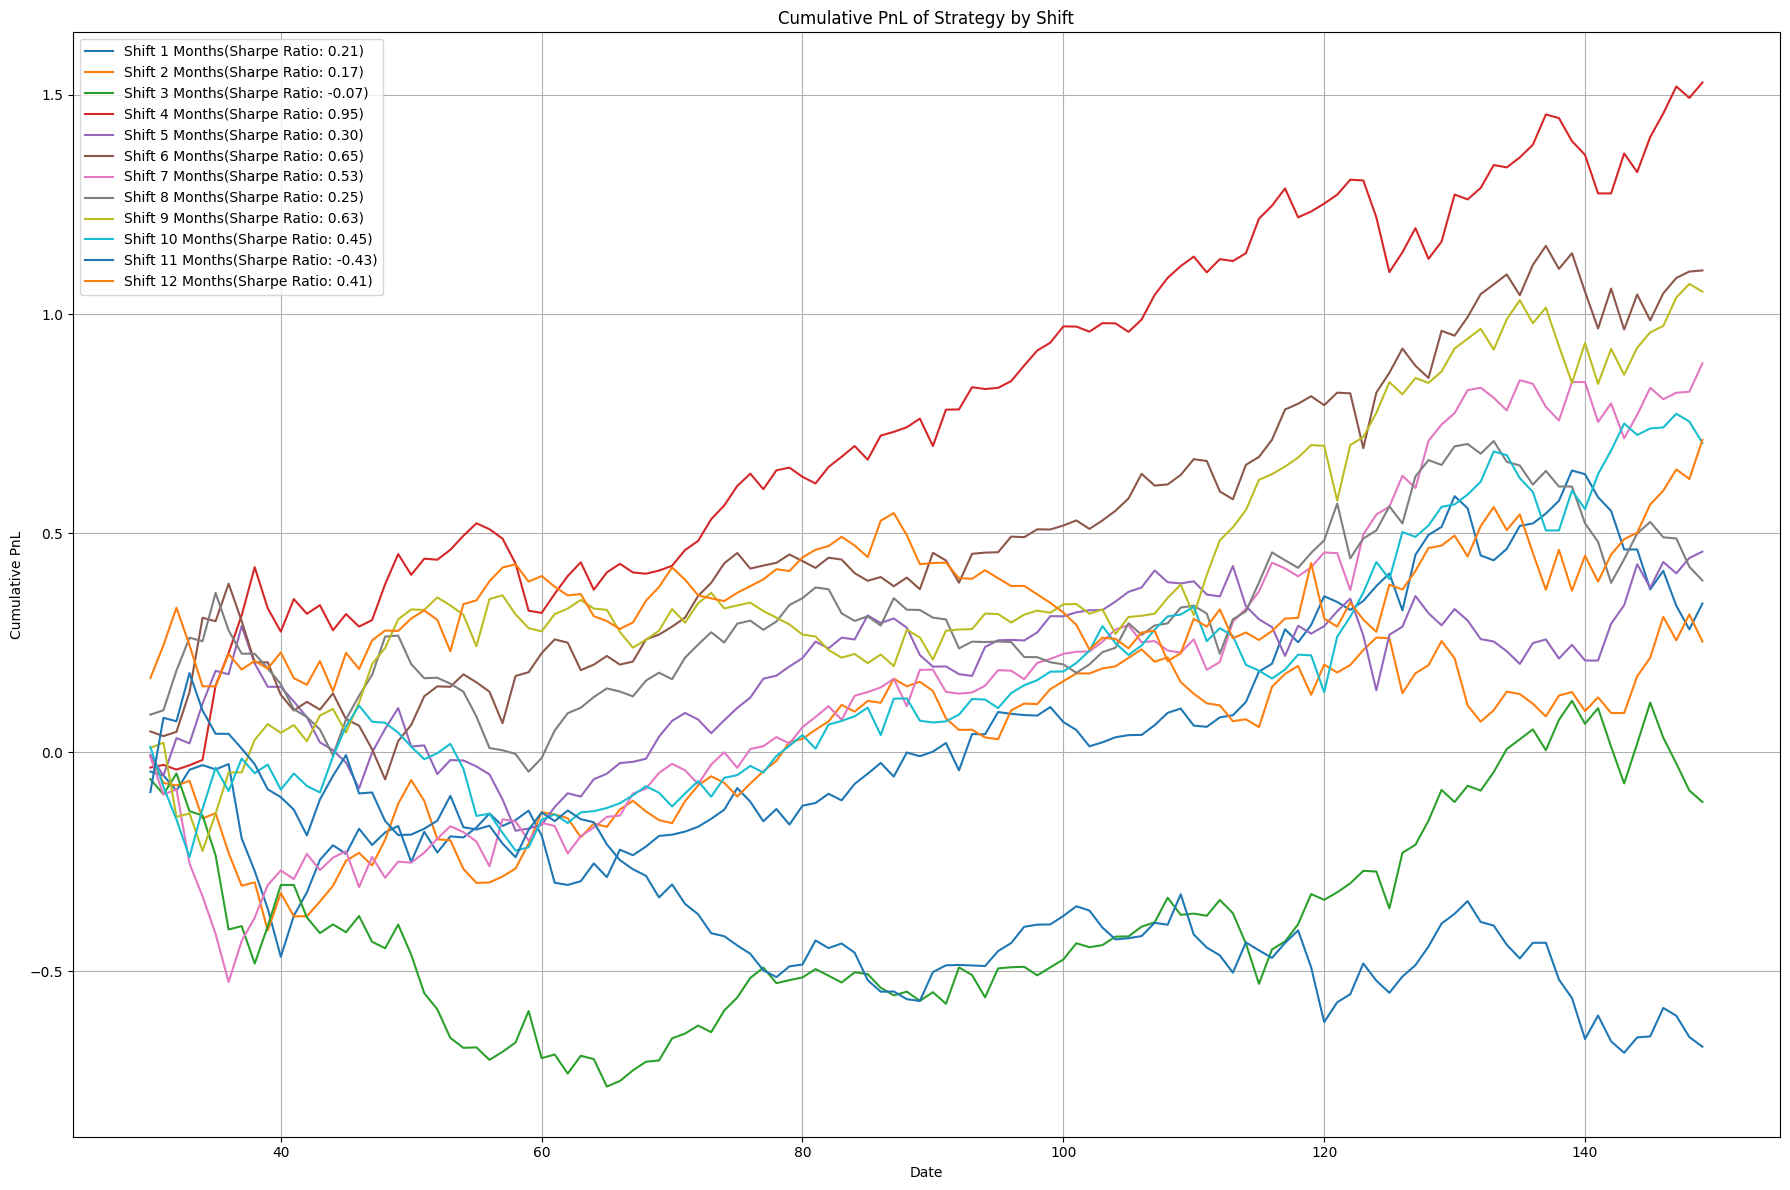

In [20]:
shifts = list(range(1, 13))
evaluate_and_visualize(
    merged_df, "target_return_", {}, shifts, model_type="Ridge", long_only=False
)  # Can use RandomForest or Ridge


Now using the Random Forest model with short selling allowed. That will allow us to see the feature importance of the model and get some insights on the impact of each one on the prediction.


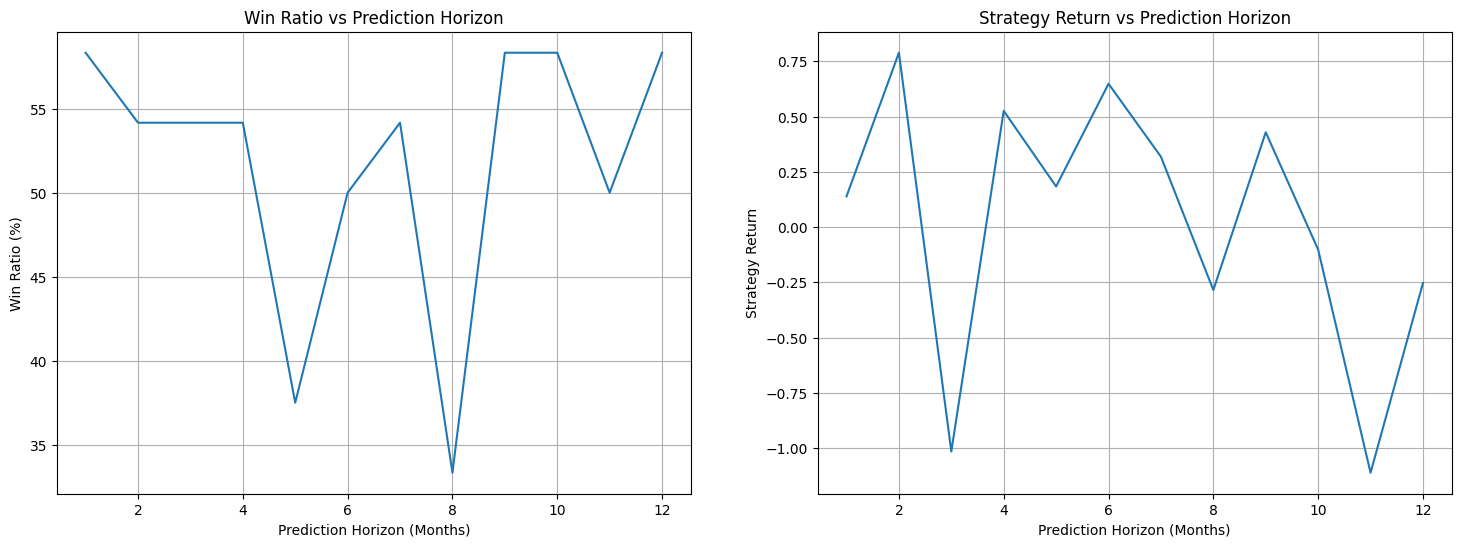

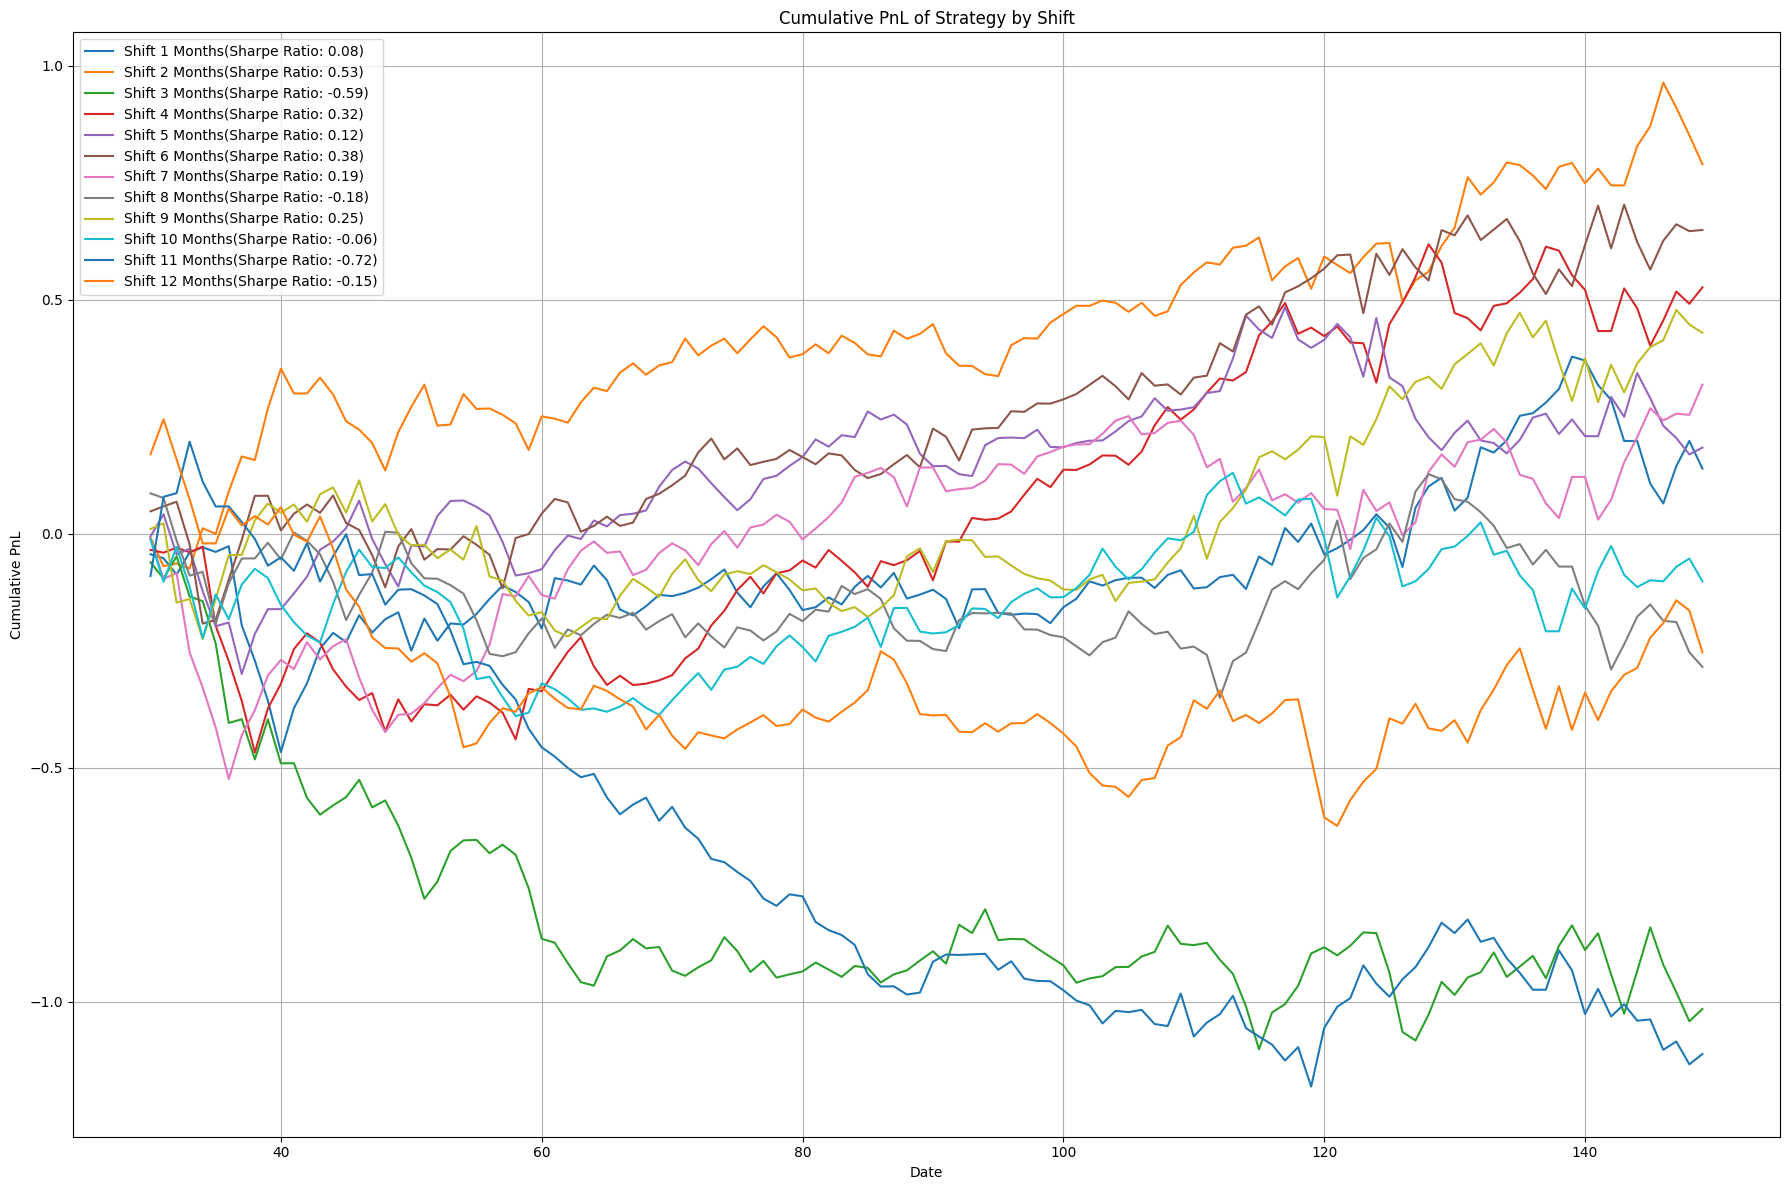

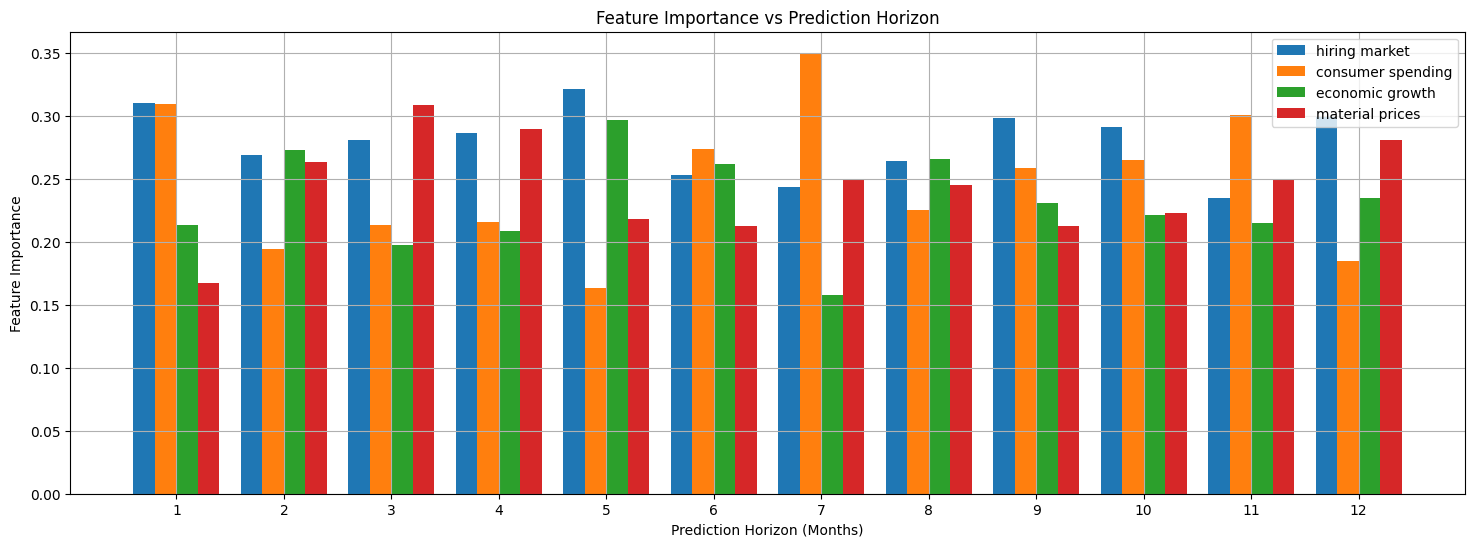

In [21]:
shifts = list(range(1, 13))
evaluate_and_visualize(
    merged_df, "target_return_", {"n_estimators": 100}, shifts, model_type="RandomForest", long_only=False
)


> It seems that the model features are somehow balanced, which means that all of them are relatively equally important for the prediction. However, that begs the question of what more complex features could be used to improve the model.


## 6. Critique of the model and future work


To conclude this project, we can see that a really simple model can already yield interesting results when using good data.
As a matter of fact, the model is not so stable when we expand the prediction horizon, but that may be improved with better features and a more complex model.


One really important point that we did not cover is the fact that we considered the S&P 500 times series as a stationary process but historically, it is not. In the last 20 years, it hasn't stopped growing and therefore, the model may not be able to predict the returns as well as it did in the past if we are confronted with a more catastrophic situation.

Another point is the low number of data points we have, which is only 20 years of quarterly data.

Finally, looking forward, a more fine-grained analysis of the data in the initial data extraction could yield better results as we sticked to a really basic extraction in four features.
